In [ ]:
import tensorflow as tf

In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# from keras_flops import get_flops


IMG_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
INITIAL_LR = 1e-5
EPOCHS = 50
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes


Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [8]:
base_model = ConvNeXtTiny(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_flow.classes),
    y=train_flow.classes
)
class_weight_dict = dict(enumerate(class_weights))

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Compiling model...


In [9]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 29,309,323
Trainable parameters: 29,305,739


In [10]:
checkpoint_cb = ModelCheckpoint(
    "best_ConvNeXtTiny_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=7, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print("Starting training ")
!curl -d "convnexttiny Train Start" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Training completed!")
!curl -d "convnexttiny Train Complete" ntfy.sh/model_complete

with open('training_history.json', 'w') as f:
    json.dump(history.history,f)
    

Starting training 
{"id":"sTppZyw1D9dQ","time":1755358500,"expires":1755401700,"event":"message","topic":"model_complete","message":"convnexttiny Train Start"}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1755358546.825679     116 service.cc:148] XLA service 0x7cd06009a110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755358546.826489     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755358551.158794     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755358555.650007     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358555.826541     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358556.070421     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358556.2654

113/445 ━━━━━━━━━━━━━━━━━━━━ 1:56 349ms/step - accuracy: 0.0356 - loss: 4.3153

E0000 00:00:1755358617.621786     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358617.797743     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358618.036738     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755358618.231371     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0339 - loss: 4.2449
Epoch 1: val_accuracy improved from -inf to 0.07863, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 355s 640ms/step - accuracy: 0.0339 - loss: 4.2447 - val_accuracy: 0.0786 - val_loss: 3.6390 - learning_rate: 1.0000e-05
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.0683 - loss: 3.7654
Epoch 2: val_accuracy improved from 0.07863 to 0.10857, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 200s 450ms/step - accuracy: 0.0684 - loss: 3.7652 - val_accuracy: 0.1086 - val_loss: 3.4077 - learning_rate: 1.0000e-05
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.1238 - loss: 3.3632
Epoch 3: val_accuracy improved from 0.10857 to 0.15274, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 203s 455ms/step - accuracy: 0.1238 - loss: 3.3630 - val_accuracy: 0.1527 - val_loss: 3.2168 - learning_rate: 1.0000e-05
Epoch 

374/374 ━━━━━━━━━━━━━━━━━━━━ 129s 334ms/step
Test Loss: 0.3005
Test Accuracy: 0.9017
Precision: 0.8662
Recall: 0.8904
F1 Score: 0.8757
Parameters: 29309323


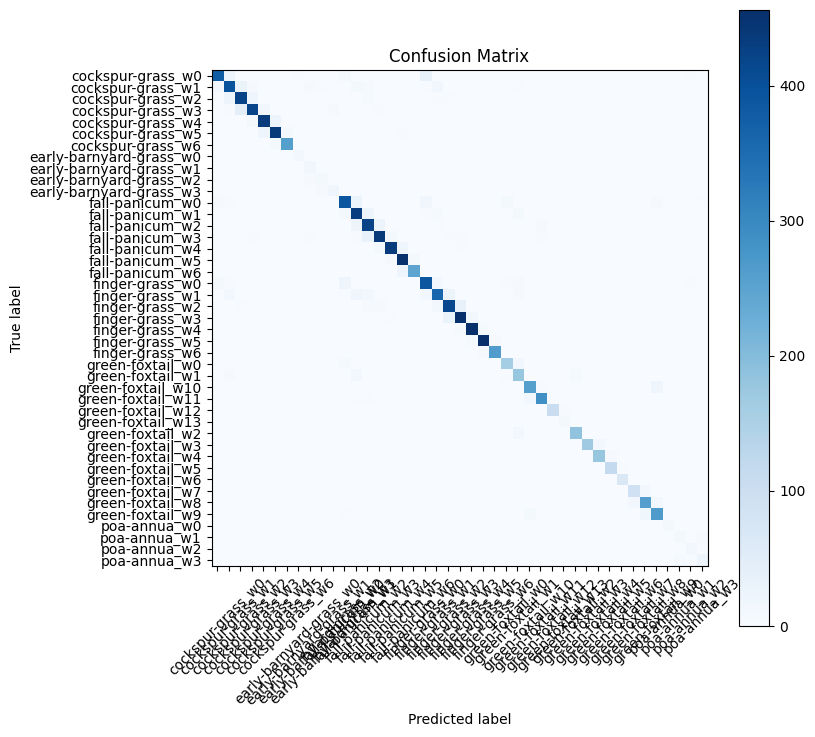

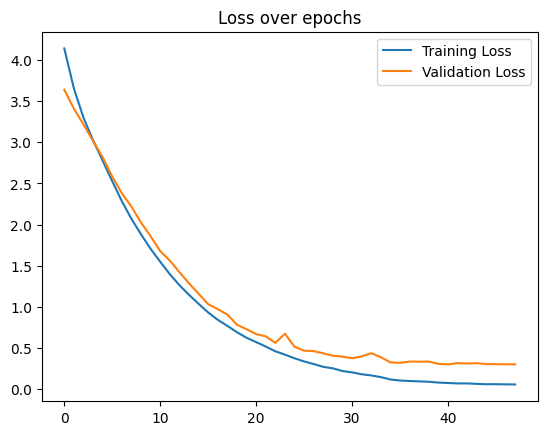

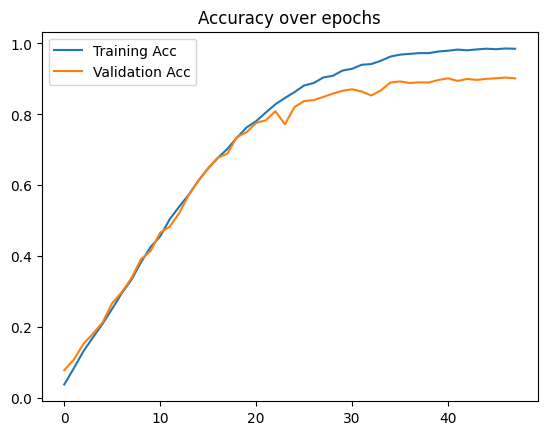

In [11]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [12]:
model.save('ConvNeXtTiny_final_model.keras')
model.save_weights('ConvNeXtTiny_final.weights.h5')

| Model        |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:-------------|---------:|------------:|-----------:|------------:|---------:|-------:|
| ConvNeXtTiny | 29309323 |      0.3005 |     0.9017 |      0.8662 |   0.8904 | 0.8757 |


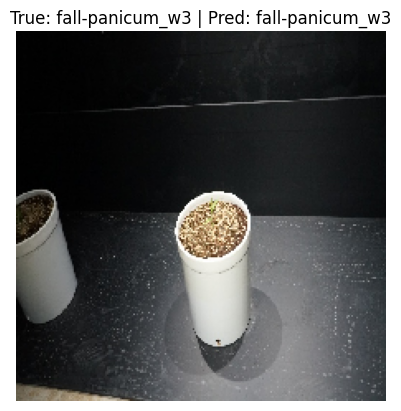

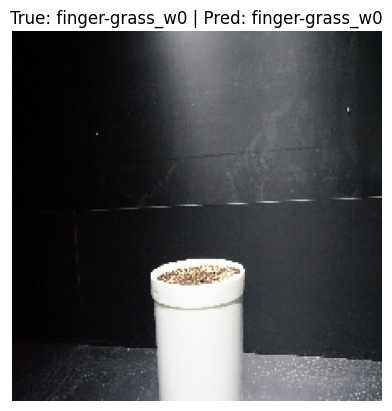

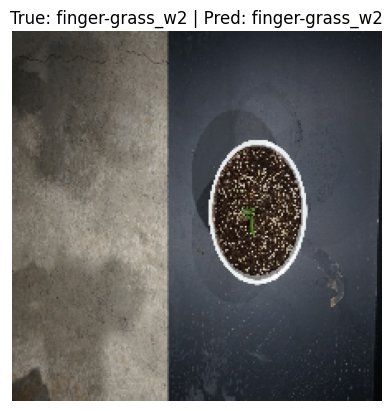

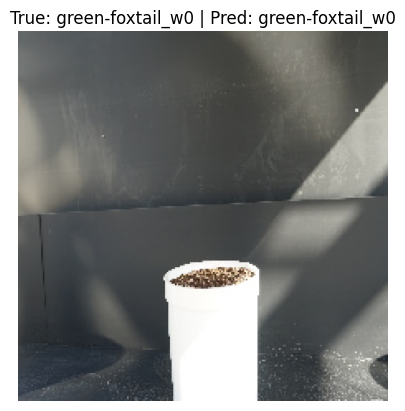

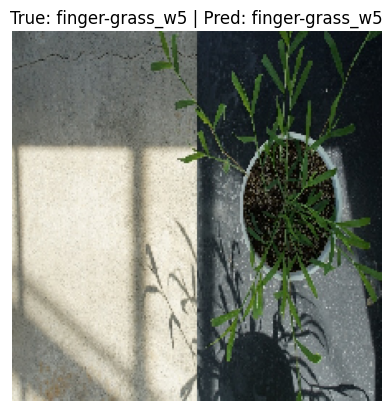

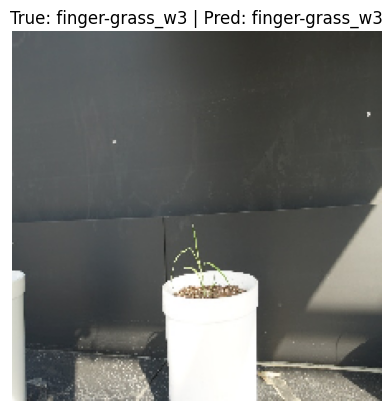

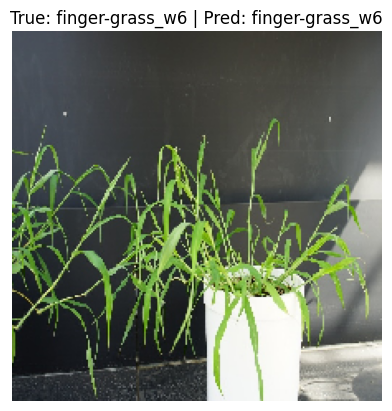

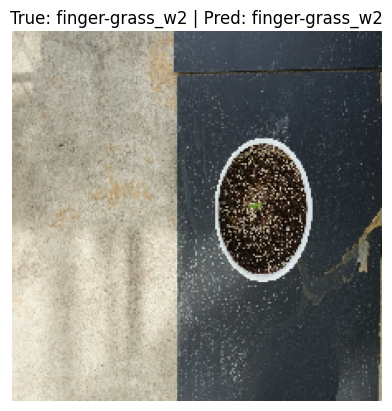

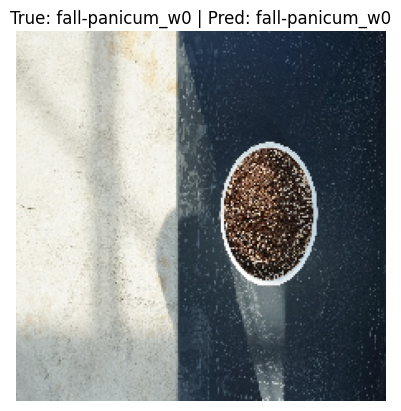

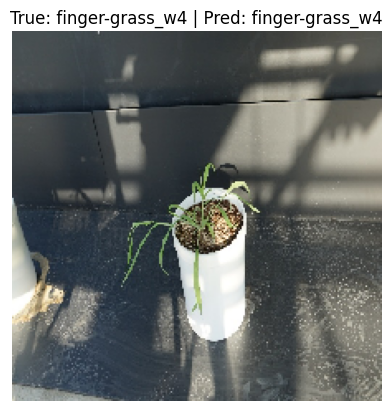

{"id":"aJ5z8UbtAffW","time":1755368466,"expires":1755411666,"event":"message","topic":"model_complete","message":"Finished"}


In [13]:
import pandas as pd
results = {
    "Model": ["ConvNeXtTiny"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "Finished" ntfy.sh/model_complete